# GEOG 5160 6160 Lab 09

You will need to make sure the following packages are installed on your computer (in addition to the packages we have used in previous labs). 

- **country_converter**: functions for working with regular arrays (`conda install country_converter`)
- **minisom**: self organizing maps (`pip install minisom`)

Let's begin by importing the packages we'll need for the lab:

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
## Set random seed for reproducibility
np.random.seed(1234)

### Data processing

The data we will use is from the [Gap Minder project][gapID]. While you can download the individual variables from the web site, we will use a preprocessed set of the data covering the period 1801-2018, in the file *gapminder_1800_2018.csv*. 

In [2]:
gap_df = pd.read_csv("../datafiles/gapminder_1800_2018.csv")
gap_df.shape

(58695, 8)

In [3]:
gap_df.head()

,country,year,child_mortality,fertility,per_cap_co2,income,life_expectancy,population
0,Afghanistan,1800,469.0,7.0,NaN,603.0,28.2,3280000
1,Afghanistan,1801,469.0,7.0,NaN,603.0,28.2,3280000
2,Afghanistan,1802,469.0,7.0,NaN,603.0,28.2,3280000
3,Afghanistan,1803,469.0,7.0,NaN,603.0,28.2,3280000
4,Afghanistan,1804,469.0,7.0,NaN,603.0,28.2,3280000


We can now make some plots to look at the data. First, histograms of the six features that we are going to use (child mortality, fertility, per capita CO2 emissions, GDP per capita, life expectancy and population size):

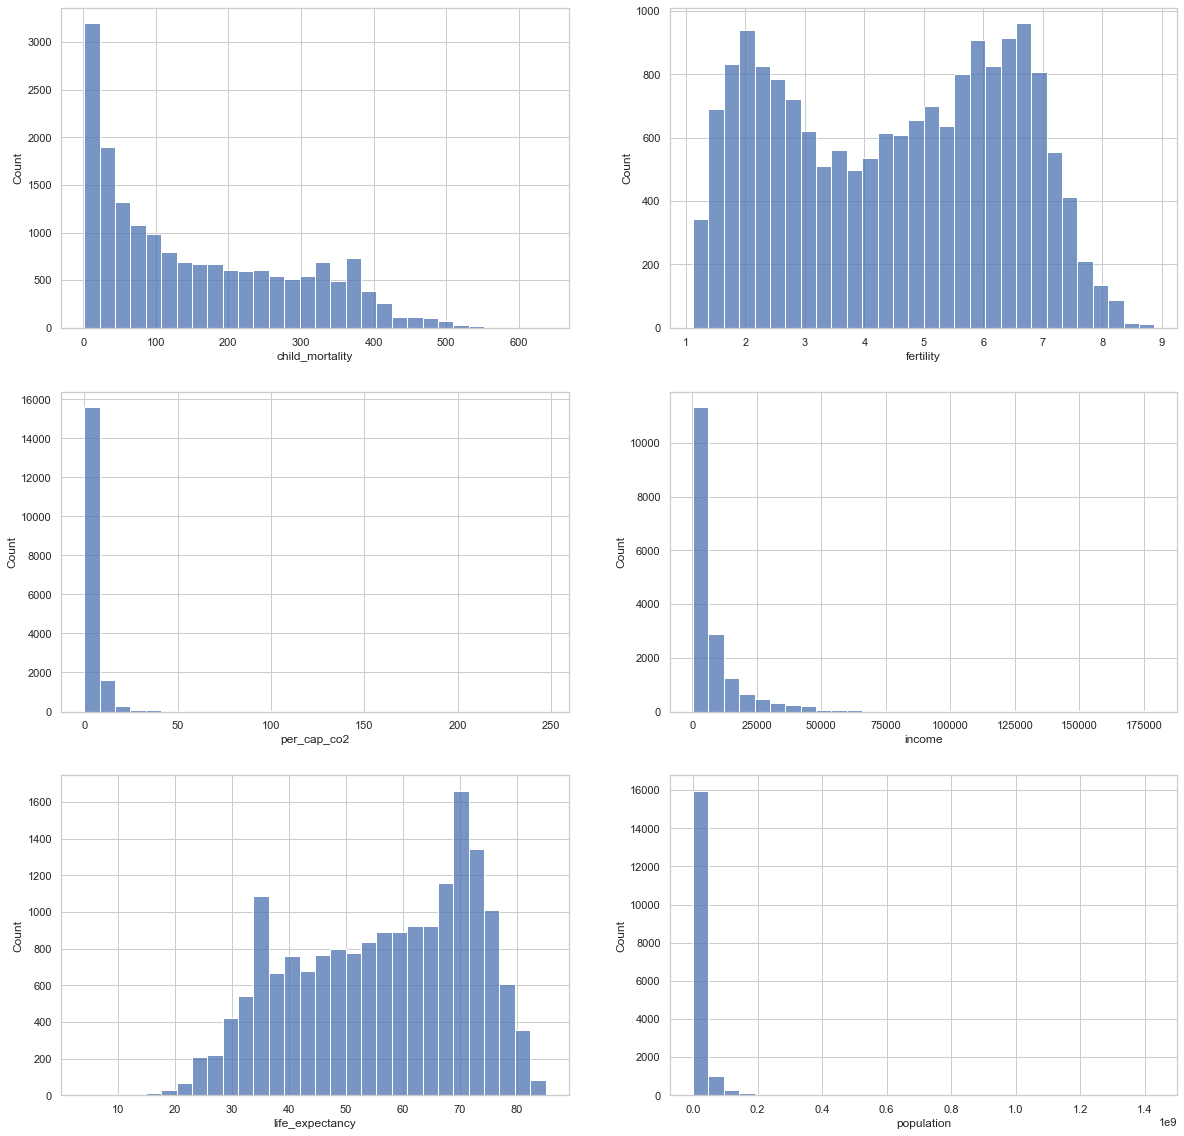

In [71]:
fig = plt.figure(figsize=(20,20))

fig.add_subplot(321)
sns.histplot(data=gap_df, x="child_mortality", bins=30)

fig.add_subplot(322)
sns.histplot(data=gap_df, x="fertility", bins=30)

fig.add_subplot(323)
sns.histplot(data=gap_df, x="per_cap_co2", bins=30)

fig.add_subplot(324)
sns.histplot(data=gap_df, x="income", bins=30)

fig.add_subplot(325)
sns.histplot(data=gap_df, x="life_expectancy", bins=30)

fig.add_subplot(326)
sns.histplot(data=gap_df, x="population", bins=30)

plt.show()

The histograms clearly show skew in most of the variables, and we will need to transform the data before analyzing it. We'll do this in two steps. First, we'll remove rows with missing observations (we could potentially impute these, but that is a little more difficult for time series data). We also remove any row where the per capita CO2 emissions are zero, partly because this would cause problems when log-transforming and partly because this is clearly not true. 

In [10]:
gap_df = gap_df.dropna()

gap_df_scale = gap_df[gap_df["per_cap_co2"] > 0]

gap_df.shape

Next, we'll log transform all variables to remove the skew, then use the `scale()` function, which in R scales data to $z$-scores by subtracting the mean and dividing by the standard deviation. To simplify things, we can do all of this in a loop by first defining the names of the columns that we want to transform. 

In [13]:
cols = ["child_mortality", "fertility", "per_cap_co2", 
        "income", "life_expectancy", "population"]

for col in cols:
    gap_df_scale[col] = np.log(gap_df_scale[col])
    gap_df_scale[col] = (gap_df_scale[col] - gap_df_scale[col].mean())/gap_df_scale[col].std()

Check the values you got (the means should be close to zero and the std. deviation close to 1):

In [15]:
gap_df_scale.describe()

,year,child_mortality,fertility,per_cap_co2,income,life_expectancy,population
count,17676.000000,1.767600e+04,1.767600e+04,1.767600e+04,1.767600e+04,1.767600e+04,1.767600e+04
mean,1958.988572,5.748337e-16,2.251097e-17,2.572682e-17,6.238755e-16,1.881274e-16,1.003346e-15
std,45.969689,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,1800.000000,-3.081631e+00,-2.539307e+00,-4.556951e+00,-2.347217e+00,-8.299730e+00,-3.016228e+00
25%,1935.000000,-7.273651e-01,-8.185993e-01,-6.579271e-01,-7.369487e-01,-6.842808e-01,-5.381645e-01
50%,1970.000000,2.277006e-01,2.839114e-01,1.109823e-01,-1.193879e-01,2.542653e-01,2.198329e-02
75%,1994.000000,8.551855e-01,8.647610e-01,7.982361e-01,6.857548e-01,8.360962e-01,6.364680e-01
max,2018.000000,1.552980e+00,1.577167e+00,2.741626e+00,3.250036e+00,1.459600e+00,3.113488e+00


The very last thing we'll do is to extract a single year of data for the first part of the lab (just 2018), and convert it to a NumPy array:

In [16]:
gap_df_scale2 = gap_df_scale[gap_df_scale.year == 2018]

X = gap_df_scale2[cols].values

## $k$-means clustering

We'll next use these data with the $k$-means cluster algorithm. Scikit-learn has several clustering algorithms in the `cluster` submodule, and the one we need is `KMeans()`. 

In [18]:
from sklearn.cluster import KMeans

We now initialize this with the following parameters: a random initialization of the cluster centroids, 6 clusters. We'll get the algorithm to run 10 times to try and avoid sub-optimal cluster solutions. (Note that the default initialization in `KMeans` is through  $k$-means++, which generally better starting solutions, and you should probably use that with your own data):

In [ ]:
kmeans = KMeans(init="random", n_clusters=6, n_init=10, random_state=42)

We can now use the `fit()` function to run the algorithm and find the clusters.

In [19]:
kmeans.fit(X)

KMeans(init='random', n_clusters=6, random_state=42)

Once run, the object it creates has several useful attributes. We can see how many iterations it took before convergence:

In [20]:
kmeans.n_iter_

10

And we can see the cluster assignments for each country in `labels_`:

In [21]:
labels = kmeans.labels_
print(labels)

[0 5 1 0 2 1 5 3 3 5 2 2 1 2 3 3 4 0 4 5 2 5 1 2 3 0 0 5 0 3 4 0 0 3 1 1 4
 0 0 5 0 3 5 2 3 3 4 5 5 1 5 4 0 2 4 0 4 3 3 4 0 5 3 0 3 2 5 0 0 4 0 5 3 2
 1 1 1 1 3 3 3 5 3 5 3 0 4 3 5 5 2 5 4 0 5 3 2 0 0 3 2 0 2 0 2 1 4 5 5 2 5
 0 5 4 5 3 3 5 0 0 5 2 3 3 0 4 5 0 5 1 1 3 3 3 3 1 0 4 4 3 0 3 2 0 3 3 3 4
 0 1 3 0 3 5 2 2 0 2 3 3 5 0 0 1 4 0 4 2 5 1 5 0 1 3 3 1 2 5 4 1 1 0 0 0]


And we can use this to see the size of each cluster (the number of observations assigned to each cluster)

In [22]:
counts = np.bincount(labels)
pd.DataFrame({"cluster": np.arange(0,6), "counts": counts})

[42 22 23 42 21 34]


And finally the `cluster_centers_`. These are the prototypes; the average value of each variable for all the observations assigned to a given cluster (note these are the log-transformed and scaled data)

In [72]:
centers = kmeans.cluster_centers_
pd.DataFrame(centers, columns = cols)

,child_mortality,fertility,per_cap_co2,income,life_expectancy,population
0,-0.213540,0.250832,-0.561977,-0.674256,0.540638,0.651507
1,-1.327011,-1.263568,0.718586,0.969633,1.052101,1.664876
2,-1.914002,-1.654313,0.921076,1.482419,1.140131,-1.247824
3,-2.343229,-1.709125,1.106859,1.883009,1.263321,0.476111
4,-0.754644,-0.414313,0.127154,0.184372,0.763327,-1.188226
5,-1.251867,-1.179543,0.416380,0.536267,1.012916,0.282379


Here, we can see that cluster 0, for example, has the lowest life expectancy and GDP, as well as high infant mortality and fertility rates. 

### Maps

As these are spatial data, we can now plot the distribution of the clusters. First, we'll load the world shapefile in the `ne_50m_admin_0_countries` folder (we used this in a previous lab). Load this using geopandas:

In [26]:
import geopandas as gpd
borders = gpd.read_file("../datafiles/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
borders.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
borders.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOU_DIF', 'GEOUNIT',
       'GU_A3', 'SU_DIF', 'SUBUNIT', 'SU_A3', 'BRK_DIFF', 'NAME', 'NAME_LONG',
       'BRK_A3', 'BRK_NAME', 'BRK_GROUP', 'ABBREV', 'POSTAL', 'FORMAL_EN',
       'FORMAL_FR', 'NAME_CIAWF', 'NOTE_ADM0', 'NOTE_BRK', 'NAME_SORT',
       'NAME_ALT', 'MAPCOLOR7', 'MAPCOLOR8', 'MAPCOLOR9', 'MAPCOLOR13',
       'POP_EST', 'POP_RANK', 'GDP_MD_EST', 'POP_YEAR', 'LASTCENSUS',
       'GDP_YEAR', 'ECONOMY', 'INCOME_GRP', 'WIKIPEDIA', 'FIPS_10_', 'ISO_A2',
       'ISO_A3', 'ISO_A3_EH', 'ISO_N3', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID',
       'WOE_ID_EH', 'WOE_NOTE', 'ADM0_A3_IS', 'ADM0_A3_US', 'ADM0_A3_UN',
       'ADM0_A3_WB', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'NAME_LEN', 'LONG_LEN', 'ABBREV_LEN', 'TINY', 'HOMEPART', 'MIN_ZOOM',
       'MIN_LABEL', 'MAX_LABEL', 'NE_ID', 'WIKIDATAID', 'NAME_AR', 'NAME_BN',
       'NAME_DE', 'NAME_

Next, we add the cluster assignments to the `gap_df_scale2` data frame:

In [28]:
gap_df_scale2 = gap_df_scale2.assign(kmeans = labels)

Now we need to merge the `gap_df_scale2` data frame with the world borders spatial object. To do this, we add a new column to the data frame containing the ISO3 standard country codes, using the convenient **country_converter** package (you'll need to install this). This contains several useful functions, including `convert()`, which takes a list of country names (or abbreviations) and matches them to standard names or codes.

In [76]:
import country_converter as coco
gap_iso3 = coco.convert(names=gap_df_scale2.country, to='ISO3', not_found=None)
gap_df_scale2 = gap_df_scale2.assign(ISO_A3 = gap_iso3)

Finally, we use these ISO codes to merge the two datasets. We need to specify the column name for each dataset that contains the label to be used in merging, which we do with `on`. 

In [78]:
borders2 = borders.merge(gap_df_scale2, on='ISO_A3')

Finally, we can plot out the clusters, which highlights the position of this poorer cluster 0 in Saharan and sub-Saharan Africa:

<AxesSubplot:>

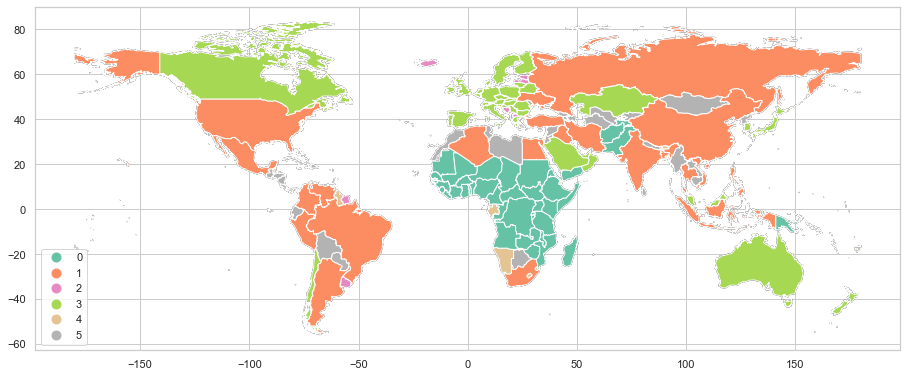

In [79]:
base = borders2.plot(figsize = (15.5, 9.5), edgecolor="black", facecolor="None")
borders2.plot(ax = base, column = 'kmeans', categorical=True, 
             cmap = 'Set2', legend = True, legend_kwds={'loc': 'lower left'})

## Hierarchical cluster analysis

We'll briefly demonstrate the use of hierarchical clustering here, using the `AgglomerativeClustering` function from scikit-learn's clustering module. 

In [80]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

This works in the same way as other scikit-learn algorithms. We first initialize the method. The two parameters we set here calculates the full hierarchy, as we do not specify a cluster number. We then use the `fit()` method with our training data `X`. 

In [81]:
hclust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hclust = hclust.fit(X)

Scikit-learn does not have a built in function to plot the dendrogram, but we can use the following code provided on their website to create a function to do so. 

In [36]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

And now use this to plot the results:

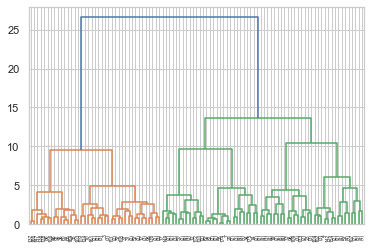

In [37]:
plot_dendrogram(hclust, truncate_mode='level', p=6)

While this gives us the full hierarchy, we don't have the cluster assignments for each country. To get clusters labels for a given number of groups, re-run the `AgglomerativeClustering` with `n_clusters` set to the number required. We then can use the `fit_predict()` method to get a vector of cluster assignments.

In [38]:
hclust = AgglomerativeClustering(n_clusters = 6)
hclust.fit_predict(X)

array([2, 0, 4, 2, 0, 1, 0, 1, 3, 0, 0, 3, 4, 0, 3, 3, 0, 2, 0, 4, 3, 0,
       1, 3, 3, 2, 2, 4, 2, 1, 0, 2, 2, 1, 1, 1, 5, 2, 5, 0, 2, 3, 3, 3,
       3, 3, 5, 0, 0, 4, 4, 0, 2, 3, 0, 2, 0, 3, 1, 0, 5, 0, 1, 2, 3, 0,
       4, 2, 5, 0, 2, 4, 3, 3, 1, 1, 1, 4, 3, 3, 1, 0, 1, 4, 3, 2, 5, 3,
       4, 4, 3, 3, 5, 2, 0, 3, 3, 2, 2, 1, 0, 2, 0, 5, 0, 1, 5, 0, 0, 3,
       4, 2, 4, 0, 4, 3, 3, 4, 2, 2, 4, 0, 3, 3, 2, 4, 0, 2, 0, 1, 4, 1,
       3, 3, 1, 1, 2, 5, 5, 3, 2, 3, 0, 2, 3, 3, 3, 5, 2, 4, 1, 2, 1, 1,
       0, 0, 2, 0, 3, 3, 4, 2, 2, 1, 5, 2, 5, 3, 0, 1, 0, 2, 1, 3, 1, 1,
       0, 4, 5, 4, 4, 2, 2, 2])

The clusters that you obtain can be used in the same way that we used the $k$-means clusters. Here, we'll append them to the country borders and map them out:

In [39]:
gap_df_scale2 = gap_df_scale2.assign(hclust = hclust.fit_predict(X))

borders2 = borders.merge(gap_df_scale2, on='ISO_A3')
base = borders2.plot(figsize = (15.5, 9.5), edgecolor="black", facecolor="None")
borders2.plot(ax = base, column = 'hclust', categorical=True, 
             cmap = 'Set2', legend = True, legend_kwds={'loc': 'lower left'})

## Self-organizing maps

We'll now repeat this analysis with a self-organizing map (SOM), but using the full dataset. Unfortunately, there is no existing method for this in scikit-learn, so we'll use the **MiniSom** package:

In [42]:
from minisom import MiniSom

We next need to create our training data by selecting the set of columns we want to use (`cols`) and converting the results into a NumPy array:

In [84]:
X = gap_df_scale[cols].values
X.shape

(17676, 6)

Now we can set up the self-organizing map. This follows a very similar process to scikit-learn. First, we initialize the grid and various parameters that control the learning:

- The first two values define the horizontal and vertical size of the SOM grid
- The next value defines the number of input features
- `sigma` specifies the size the neighborhood radius. This has been set to quite a high value here to force a relatively smooth organization
- `learning_rate` controls the rate of update to each nodes weights. Both this and `sigma` are reduced over the training period to focus on finer scale patterns in the data
- `neighborhood_function` defines the shape of spatial decay in the neighborhood updates
- `topology` is either rectangular or hexagonal. Note the any visualization of the hexagonal topology will appear rectangular due to limits in the package

In [85]:
som = MiniSom(30, 20, X.shape[1], sigma=10., learning_rate=.75, 
              neighborhood_function='gaussian', topology = 'hexagonal',
              random_seed=0)

Once the SOM is set up, we initialize the weights of each node randomly, then train it with the training data for 10000 iterations. 

In [86]:
som.random_weights_init(X)
som.train(X, 10000, verbose=True)  # random training

 [   638 / 10000 ]   6% - 0:00:02 left 

 [  1222 / 10000 ]  12% - 0:00:02 left 

 [  1826 / 10000 ]  18% - 0:00:02 left 

 [  2449 / 10000 ]  24% - 0:00:02 left 

 [  3035 / 10000 ]  30% - 0:00:02 left 

 [  3630 / 10000 ]  36% - 0:00:02 left 

 [  4229 / 10000 ]  42% - 0:00:01 left 

 [  4825 / 10000 ]  48% - 0:00:01 left 

 [  5422 / 10000 ]  54% - 0:00:01 left 

 [  5990 / 10000 ]  60% - 0:00:01 left 

 [  6562 / 10000 ]  66% - 0:00:01 left 

 [  7109 / 10000 ]  71% - 0:00:00 left 

 [  7701 / 10000 ]  77% - 0:00:00 left 

 [  8280 / 10000 ]  83% - 0:00:00 left 

 [  8868 / 10000 ]  89% - 0:00:00 left 

 [  9431 / 10000 ]  94% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 


 quantization error: 1.0368586248106477


This function does not provide a way to visualize the changes fit of the SOM to the data over the set of iterations. The appendix contains code that will allow you to track and plot this, but it is fairly time consuming so we'll skip it here. 

Instead, we can start to plot some of the outputs. First, we'll plot the U-matrix, a representation of the dissimilarity between each node and it's immediate neighbors. This shows the non-linearity of the new representation of the data, with some regions of quite high values (high dissimilarity) dividing up the map.

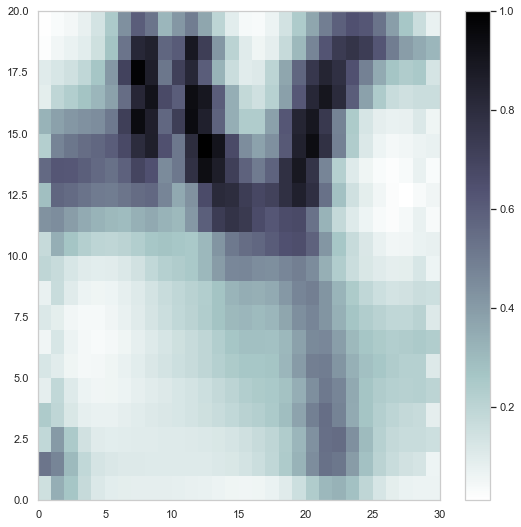

In [44]:
plt.figure(figsize=(9, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r')
plt.colorbar()

Next, we'll plot the codebook vectors. These are the weights associated with each feature, and can be used to interpret the organization of the SOM. First, we need to extract these from the trained SOM using `get_weights()`:

In [45]:
som_weights = som.get_weights()

som_weights.shape

We can plot out the weights for individual feature weights as a heatmap to illustrate the gradients in the map, and to help in interpreting the results. Here we plot all six together:

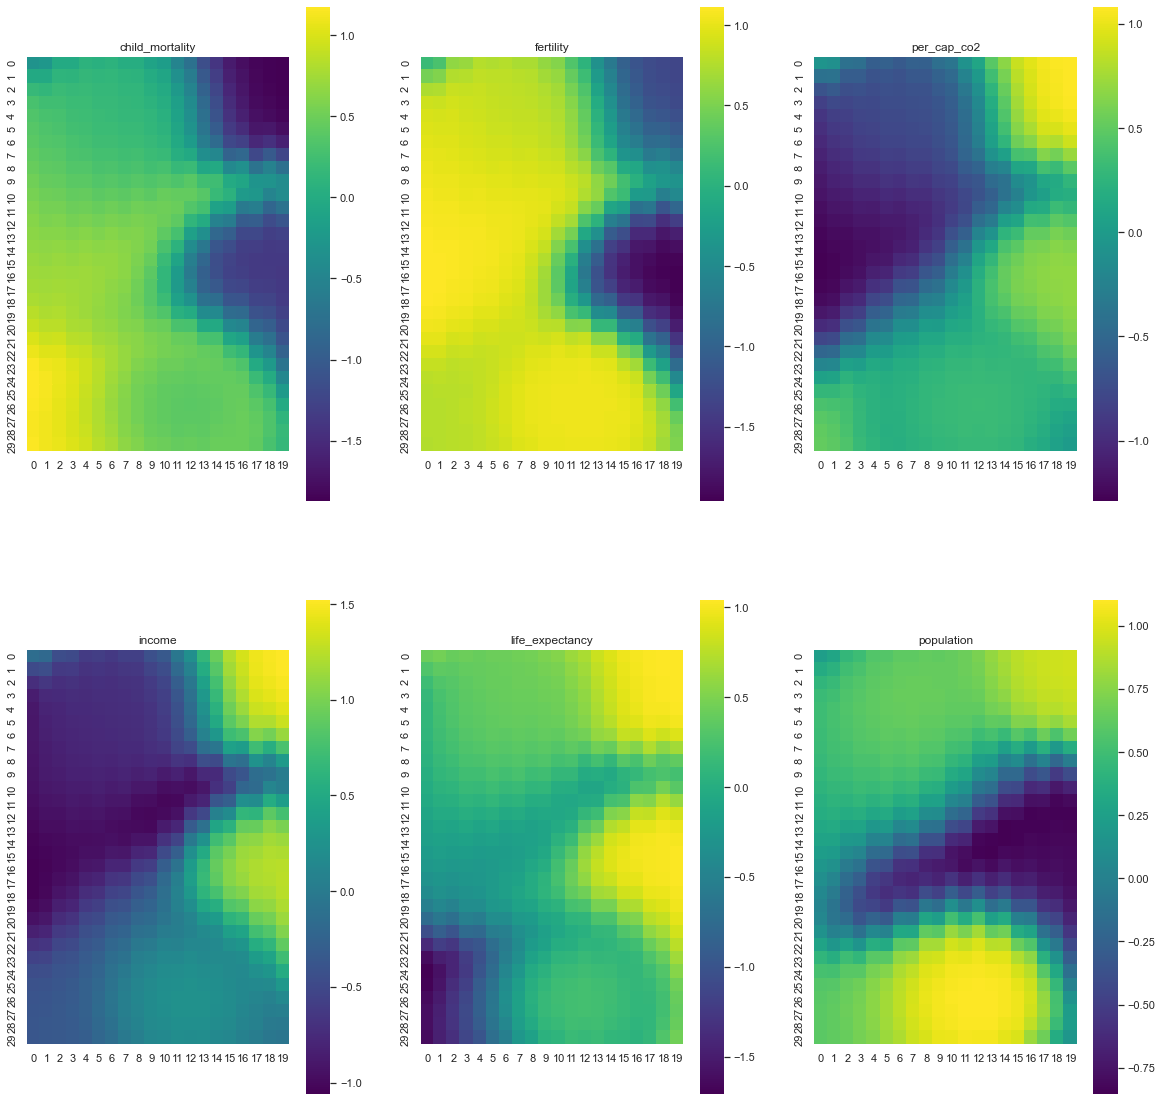

In [95]:
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(231, aspect='equal')
plot_var = 0
sns.heatmap(som_weights[:,:,plot_var], cmap="viridis")
ax1.set_title(cols[plot_var])

ax2 = fig.add_subplot(232, aspect='equal')
plot_var = 1
sns.heatmap(som_weights[:,:,plot_var], cmap="viridis")
ax2.set_title(cols[plot_var])

ax3 = fig.add_subplot(233, aspect='equal')
plot_var = 2
sns.heatmap(som_weights[:,:,plot_var], cmap="viridis")
ax3.set_title(cols[plot_var])

ax4 = fig.add_subplot(234, aspect='equal')
plot_var = 3
sns.heatmap(som_weights[:,:,plot_var], cmap="viridis")
ax4.set_title(cols[plot_var])

ax5 = fig.add_subplot(235, aspect='equal')
plot_var = 4
sns.heatmap(som_weights[:,:,plot_var], cmap="viridis")
ax5.set_title(cols[plot_var])

ax6 = fig.add_subplot(236, aspect='equal')
plot_var = 5
sns.heatmap(som_weights[:,:,plot_var], cmap="viridis")
ax6.set_title(cols[plot_var])

plt.show()

The main gradient is between the left of the map, with low life expectancy, high child mortality and low per capita income and CO2 emissions. The right hand side of the map shows values that are largely the inverse of this. There are two clear areas of high income and life expectancy on the right; if you look at the population map, you should see that these correspond to rich countries with high and low population sizes. 

We can now run a cluster analysis on these results to simplify the map. The SOM weights are held in a 3D array (the third dimension corresponds to the features). If this is reshaped into a 2D array, with each row corresponding to a SOM node, and each column to a feature, we can then use this to train a cluster method (we'll use hierarchical clustering here):

In [87]:
X_som = som_weights.reshape(600,6)

hclust = AgglomerativeClustering(n_clusters = 6)
som_clust = hclust.fit_predict(X_som)

We can now plot out these clusters. Note that as we have clustered the SOM nodes (not the original observations), we can't yet visualize these on a map, but we can replot the SOM grid and shade each node by it's cluster membership:

<AxesSubplot:>

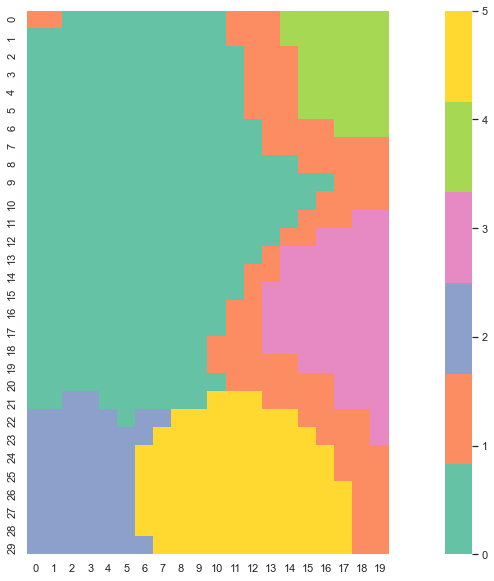

In [96]:
clus_cmap = sns.color_palette("Set2", 6)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, aspect='equal')
sns.heatmap(som_clust.reshape(30,20), cmap=clus_cmap)

As we have data over multiple years, we can also use the results of the SOM analysis to track the change made by an individual country over time. To do this, we need to know which node a country was assigned to for each of it's time steps. For this, we can take advantage of the `winner()` method. This returns the grid coordinates for the best matching unit for any observation. For example, to find the BMU for the first value in X:

In [ ]:
som.winner(X[0,:])

To do this for all observations for a country, we first make a new dataset corresponding to that country (e.g. here for the United States)

In [97]:
X_country = X[gap_df_scale['country'] == "United States", :]
X_country.shape

(219, 6)

Next, we need to find the node assigned to each of those observations using the `winner()` method. As this only works for a single observation, we create a simple method that we can then use with NumPy's `apply_along_axis()` function. 

In [98]:
def get_node_crds( x ):
    return som.winner(x)
country_crds = np.apply_along_axis( get_node_crds, axis=1, arr=X_country )
country_crds

array([[20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [20,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [21,  0],
       [22,  1],
       [22,  1],
       [22,  1],
       [22,  1],
       [22,  1],
       [22,  2],
       [22,  2],
       [22,  2],
       [22,  2],
       [22,  2],
       [22,  2],
       [22,  2],
       [23,  3],
       [23,  4],
       [23,  4],
       [23,  4],
       [23,  4],
       [23,  4],
       [24,  4],
       [24,  4],
       [29,  4],
       [29,  4],
       [29,  4],
       [29,  4],
       [29,  4],
       [29,  4],
       [29,  4],
       [29,  4

Now we plot out the grid again, shaded with the cluster assignments. Then we use matplotlib's `plot()` function to overlay the country's trajectory. We also add a text label for the first and last observation to illustrate the start and end.

Text(19, 0, '2018')

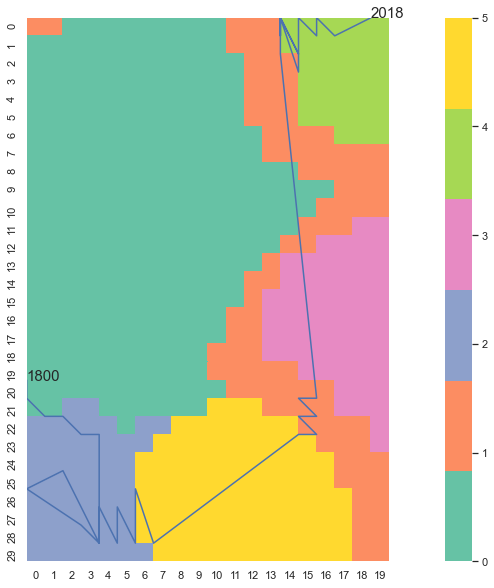

In [99]:
#crds_0 = som_win
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, aspect='equal')
sns.heatmap(som_clust.reshape(30,20), cmap=clus_cmap)
plt.plot(country_crds[:,1], country_crds[:,0])
ax.text(country_crds[0,1], 
        country_crds[0,0], 
        r'1800', fontsize=15)
ax.text(country_crds[-1,1], 
        country_crds[-1,0], 
        r'2018', fontsize=15)

Next, we obtain aggregate values of the features for each cluster. This is a little involved. First we use the same function we created earlier to extract the SOM node for each observation in the full dataset. 

In [100]:
all_crds = np.apply_along_axis(get_node_crds, axis=1, arr=X)
all_crds

array([[20,  0],
       [21,  0],
       [21,  0],
       ...,
       [ 0,  0],
       [ 7, 14],
       [ 7, 14]])

Next we need an array of the cluster assignments for each node that corresponds to these node coordinates. TO do this, we reshape the 1D array `som_clust` to match the SOM grid:

In [101]:
som_clust_array = som_clust.reshape(30,20)

We now use the grid coordinates for each observation to extract the cluster number for the node to which that observation was assigned:

In [61]:
tmp_clust = som_clust_array[all_crds[:,0], all_crds[:,1]]

tmp_clust.shape

And finally, we merge this back into the original dataset, and use Panda's `mean()` function to calculate the mean by cluster:

In [102]:
gap_df_scale = gap_df_scale.assign(som_clust = tmp_clust)

gap_df_scale.groupby('som_clust').mean()

,year,child_mortality,fertility,per_cap_co2,income,life_expectancy,population
som_clust,,,,,,,
0,1950.811232,0.610287,0.764969,-0.893557,-0.794336,-0.417659,-0.282877
1,1971.216593,-0.217203,-0.230561,0.487037,0.322017,0.532451,0.050402
2,1902.736446,1.057298,0.603436,-0.239696,-0.621713,-1.505505,0.407075
3,1988.683837,-1.194742,-1.242062,0.900540,1.107541,0.932775,-0.771719
4,1996.313522,-1.623421,-1.497712,1.098666,1.423936,1.070394,0.845241
5,1968.370056,0.533889,0.724279,0.188091,0.046721,0.094519,1.353396


This shows the approximate characteristics for the clusters:

0. Low life expectancy and GDP, high mortality and fertility rates, small population
1. High life expectancy and GDP, lower mortality and fertility rates, medium population
2. Low life expectancy and GDP, very high mortality and fertility rates, medium population
3. High life expectancy and medium GDP, medium mortality and fertility rates, small population
4. High life expectancy and GDP, low mortality and fertility rates, medium population
5. Medium life expectancy, low GDP, medium mortality and fertility rates, large population

Note that there is also a progression in time, with clusters that tend to occur later having lower child mortality but higher CO2 emissions

And finally, we can plot out the spatial distribution of these clusters for any given year in the dataset. First we extract the year we want to visualize:

In [65]:
gap_df_2000 = gap_df_scale[gap_df_scale.year == 2000]
gap_df_2000

,country,year,child_mortality,fertility,per_cap_co2,income,life_expectancy,population,som_clust
200,Afghanistan,2000,0.304060,1.240771,-1.478372,-1.651689,0.038199,0.752357,0
501,Albania,2000,-0.951595,-1.232799,0.084916,0.171608,1.053372,-0.304686,3
802,Algeria,2000,-0.617570,-0.934063,0.598304,0.734110,1.014551,0.975067,1
1404,Angola,2000,0.670115,1.001150,-0.158718,-0.123907,-0.137064,0.619706,0
1705,Antigua and Barbuda,2000,-1.338116,-1.090649,0.826497,1.353397,1.044786,-2.379823,3
...,...,...,...,...,...,...,...,...,...
57390,Venezuela,2000,-1.093578,-0.702405,0.981972,1.041527,1.014551,0.836856,4
57691,Vietnam,2000,-0.839279,-1.375974,-0.101269,-0.489151,0.904184,1.503493,1
57992,Yemen,2000,0.063976,0.899745,0.013356,-0.099335,0.513002,0.652741,1
58293,Zambia,2000,0.482201,0.812751,-0.742035,-0.654618,-0.512203,0.365494,0


Again, we need to add the ISO3 country code to allow this to be merged with the country outlines:

In [67]:
gap_iso3 = coco.convert(names=gap_df_2000.country, to='ISO3', not_found=None)
gap_df_2000 = gap_df_2000.assign(ISO_A3 = gap_iso3)

In [68]:
borders2 = borders.merge(gap_df_2000, on='ISO_A3')
borders2.columns

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN', 'ADM0_A3',
       ...
       'geometry', 'country', 'year', 'child_mortality', 'fertility',
       'per_cap_co2', 'income', 'life_expectancy', 'population', 'som_clust'],
      dtype='object', length=104)

And finally, plot it:

<AxesSubplot:>

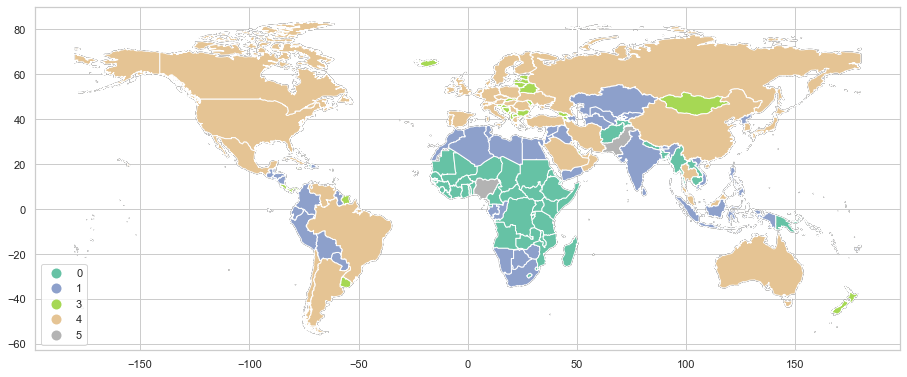

In [69]:
base = borders2.plot(figsize = (15.5, 9.5), edgecolor="black", facecolor="None")
borders2.plot(ax = base, column = 'som_clust', categorical=True, 
             cmap = 'Set2', legend = True, legend_kwds={'loc': 'lower left'})

## Exercise

For the exercise, you will need to build use an unsupervised classification method with the California housing dataset using a self-organizing map. Your answer should use the following variables (you can use code from a previous example to create the average number of rooms per house, and the ratio of bedrooms to rooms):

- `housing_median_age` 
- `population`
- `median_income`
- `median_house_value` 
- `avg_rooms`
- `bedroom_ratio`

Your answer should consist of the following:

- Your python code as a notebook or in a word document
- A plot of the U-matrix
- A plot of the codebook vectors
- One or more heatmaps of the individual features on the SOM
- A set of clusters constructed from the SOM nodes using the method in the lab (and a figure showing these on the SOM grid)
- A table given the average values of each feature per cluster

You do not need to provide a map of the cluster assignments, but I'd encourage you to try this if you can. 

## Appendix

Code to run and show the training values for the self-organized maps (will take a while to run)